# Description Model Approach 3: Fine-Tuning a Classification Model

This Notebook is a combination of these approaches:
* Fine-tuned classification model. Use the csv files to fine-tune a pre-trained classification model. Apply the model to the linked-in data

*  Use rule-based or embedding-based predictions to create pseudo-labels for a large set of LinkedIn profiles, then fine-tune a classifier on this expanded dataset.


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)


In [3]:
# GitHub raw helper
GH_USER = "luisadosch"
GH_REPO = "Final-Project-snapAddy"
BRANCH = "main"


def get_github_url(relative_path):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/{relative_path}"

In [4]:
jobs_annotated = pd.read_csv(get_github_url("data/processed/jobs_annotated.csv"))
df_seniority = pd.read_csv(get_github_url("data/raw/seniority-v2.csv"))

# test set from annotated CVs (ACTIVE only)
df_seniority_test = jobs_annotated.loc[jobs_annotated["status"] == "ACTIVE", ["position", "seniority"]].copy()
df_seniority_test = df_seniority_test.rename(columns={"position": "text", "seniority": "label"})

# base train/test dfs (strings)
train_df_base = df_seniority[["text", "label"]].copy()
test_df_base = df_seniority_test[["text", "label"]].copy()

print("train:", len(train_df_base), "test:", len(test_df_base))
print("train label counts:\n", train_df_base["label"].value_counts())
print("test label counts:\n", test_df_base["label"].value_counts())


train: 9428 test: 623
train label counts:
 label
Senior        3733
Lead          3546
Director       984
Management     756
Junior         409
Name: count, dtype: int64
test label counts:
 label
Professional    216
Management      192
Lead            125
Senior           44
Director         34
Junior           12
Name: count, dtype: int64


As we can see, the label Professional is missing from the test set. Because of this, we switch from a classification approach to linear regression, which avoids issues caused by unseen classes during evaluation.

In [5]:
ORD_MAP = {
    "Junior": 1.0,
    "Professional": 2.0,
    "Senior": 3.0,
    "Lead": 4.0,
    "Management": 5.0,
    "Director": 6.0,
}
INV_ORD = {v: k for k, v in ORD_MAP.items()}

In [6]:
def add_synthetic(train_df: pd.DataFrame, synthetic_csv_relpath: str) -> pd.DataFrame:
    syn = pd.read_csv(get_github_url(synthetic_csv_relpath))
    syn = syn[["position", "seniority"]].copy()

    id2label = {v: k for k, v in ORD_MAP.items()}
    syn["label"] = syn["seniority"].map(id2label)
    syn = syn.rename(columns={"position": "text"})
    syn = syn.dropna(subset=["text", "label"])

    out = pd.concat([train_df[["text", "label"]], syn[["text", "label"]]], ignore_index=True)
    return out

Tokenizer + Tokenization

In [7]:
MODEL_CKPT = "xlm-roberta-base"
MAX_LEN = 48

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [8]:
def to_hf_dataset(df: pd.DataFrame, label_col: str = "labels") -> Dataset:
    ds = Dataset.from_pandas(df[["text", label_col]].copy(), preserve_index=False)
    ds = ds.map(tokenize, batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", label_col])
    return ds

In [9]:
def eval_split(trainer, train_ds, val_ds, test_ds):
    train_metrics = trainer.evaluate(train_ds, metric_key_prefix="train")
    val_metrics   = trainer.evaluate(val_ds,   metric_key_prefix="val")
    test_metrics  = trainer.evaluate(test_ds,  metric_key_prefix="test")
    print("Evaluation based on training data:", train_metrics)
    print("Evaluation based on val data:  ", val_metrics)
    print("Evaluation based on test data: ", test_metrics)
    return train_metrics, val_metrics, test_metrics

In [10]:
def loss_curves(trainer):
    logs = pd.DataFrame(trainer.state.log_history)

    train_loss = logs.dropna(subset=["loss"])[["step", "loss"]].copy()
    eval_loss  = logs.dropna(subset=["eval_loss"])[["step", "eval_loss"]].copy()

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(train_loss["step"], train_loss["loss"])
    plt.xlabel("step")
    plt.ylabel("train loss")
    plt.title("Train loss")
    plt.show()

    plt.figure()
    plt.plot(eval_loss["step"], eval_loss["eval_loss"])
    plt.xlabel("step")
    plt.ylabel("eval loss")
    plt.title("Eval loss")
    plt.show()

    return logs

## Model Pipeline for Regression based prediction

In [11]:


def score_to_label(s: float) -> str:
  # because we used accuracy for other classification models, we also want to get an accuracy here
    if s < 1.5: return "Junior"
    if s < 2.5: return "Professional"
    if s < 3.5: return "Senior"
    if s < 4.5: return "Lead"
    if s < 5.5: return "Management"
    return "Director"

def compute_metrics_reg(eval_pred):
    preds, labels = eval_pred
    scores = np.squeeze(preds)
    mae = mean_absolute_error(labels, scores)

    y_pred = [score_to_label(float(s)) for s in scores]
    y_true = [INV_ORD[float(int(round(x)))] for x in labels]

    return {
        "mae": mae,
        "acc_thresh": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }




In [12]:
def predict_table_reg(trainer, ds, df_text_label):
    pred = trainer.predict(ds)
    scores = np.squeeze(pred.predictions)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_score"] = scores
    out["pred_label"] = [score_to_label(float(s)) for s in scores]
    out["abs_err"] = (out["pred_score"] - out["label"].map(ORD_MAP).astype(float)).abs()
    return out.sort_values("abs_err", ascending=False)

In [13]:
def run_regression(train_df: pd.DataFrame, test_df: pd.DataFrame, out_dir: str = "seniority_ft_reg"):
    tr = train_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(ORD_MAP).astype(float)
    te["labels"] = te["label"].map(ORD_MAP).astype(float)

    # CHANGE HERE if you want different split size / stratify:
    train_sub, val = train_test_split(
        tr,
        test_size=0.2,
        stratify=tr["label"],
        random_state=42,
    )

    train_ds = to_hf_dataset(train_sub, label_col="labels")
    val_ds   = to_hf_dataset(val,       label_col="labels")
    test_ds  = to_hf_dataset(te,        label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=1,
        problem_type="regression",
    )

    # CHANGE HERE for hyperparams / logging / epochs:
    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="mae",
        greater_is_better=False,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_reg,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_reg(trainer, train_ds, train_sub[["text", "label"]])
    val_pred   = predict_table_reg(trainer, val_ds,   val[["text", "label"]])
    test_pred  = predict_table_reg(trainer, test_ds,  te[["text", "label"]])

    display(test_pred.head(30))
    return trainer, (train_pred, val_pred, test_pred)


Classification pipeline (seniority labels)

In [14]:
def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }


In [15]:
def predict_table_cls(trainer, ds, df_text_label, id2label):
    pred = trainer.predict(ds)
    probs = pred.predictions
    y_pred = np.argmax(probs, axis=-1)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_id"] = y_pred
    out["pred_label"] = [id2label[int(i)] for i in y_pred]
    out["correct"] = (out["pred_label"] == out["label"])
    return out

In [16]:
def report_cls(trainer, ds, id2label):
    pred = trainer.predict(ds)
    y_pred = np.argmax(pred.predictions, axis=-1)
    y_true = pred.label_ids
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

In [17]:
from sklearn.utils import resample
def oversample_df(df, label_col="label", random_state=42):
    max_n = df[label_col].value_counts().max()
    parts = []
    for lab, g in df.groupby(label_col):
        parts.append(resample(g, replace=True, n_samples=max_n, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)

def run_classification(train_df: pd.DataFrame, test_df: pd.DataFrame, out_dir: str = "seniority_ft_cls"):
    # label space ONLY from train_df (no leakage)
    label_list = sorted(train_df["label"].unique())
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    tr = train_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(label2id).astype(int)
    te["labels"] = te["label"].map(label2id)

    print("labels:", label_list)
    print("test missing labels:", int(te["labels"].isna().sum()))

    # IMPORTANT: drop test rows with unseen labels (otherwise crashes)
    te = te.dropna(subset=["labels"]).copy()
    te["labels"] = te["labels"].astype(int)


    train_sub, val = train_test_split(
        tr, test_size=0.2, stratify=tr["label"], random_state=42
        )


    train_sub_os = oversample_df(train_sub, label_col="label")
    train_ds = to_hf_dataset(train_sub_os, label_col="labels")
    val_ds   = to_hf_dataset(val,          label_col="labels")
    test_ds  = to_hf_dataset(te,        label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    # CHANGE HERE for hyperparams / logging / epochs:
    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=False,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_cls,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_cls(trainer, train_ds, train_sub_os[["text", "label"]], id2label)
    val_pred   = predict_table_cls(trainer, val_ds,   val[["text", "label"]], id2label)
    test_pred  = predict_table_cls(trainer, test_ds,  te[["text", "label"]], id2label)

    display(test_pred.head(30))
    report_cls(trainer, val_ds, id2label)

    return trainer, (train_pred, val_pred, test_pred), (label2id, id2label)

## Model Runs

Fine tuned Regression without synthetic data

In [18]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
print("current device:", torch.cuda.current_device() if torch.cuda.is_available() else None)
print("gpu name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

torch: 2.9.0+cu126
cuda available: True
cuda device count: 1
current device: 0
gpu name: NVIDIA A100-SXM4-40GB


Map:   0%|          | 0/7542 [00:00<?, ? examples/s]

Map:   0%|          | 0/1886 [00:00<?, ? examples/s]

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2199740445.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mae,Acc Thresh,F1 Macro
1,0.428200,0.260513,0.340903,0.863203,0.557700
2,0.169100,0.132717,0.243995,0.939555,0.736274
3,0.057100,0.101265,0.199967,0.981972,0.974921
4,0.054300,0.083763,0.189467,0.986214,0.815247
5,0.041400,0.062333,0.194238,0.993637,0.992230
6,0.029800,0.047713,0.167419,0.993107,0.989756
7,0.022300,0.040522,0.159227,0.994698,0.827832
8,0.020600,0.036793,0.159814,0.995228,0.993048
9,0.016200,0.041510,0.168847,0.994698,0.992232


early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled


Evaluation based on training data: {'train_loss': 0.03292718529701233, 'train_mae': 0.15535740554332733, 'train_acc_thresh': 0.9984089101034208, 'train_f1_macro': 0.8320083530374199, 'train_runtime': 4.0397, 'train_samples_per_second': 1866.959, 'train_steps_per_second': 58.42, 'epoch': 9.0}
Evaluation based on val data:   {'val_loss': 0.04052232578396797, 'val_mae': 0.15922680497169495, 'val_acc_thresh': 0.9946977730646872, 'val_f1_macro': 0.8278321646382084, 'val_runtime': 1.0864, 'val_samples_per_second': 1735.982, 'val_steps_per_second': 54.307, 'epoch': 9.0}
Evaluation based on test data:  {'test_loss': 1.4769573211669922, 'test_mae': 0.8556059002876282, 'test_acc_thresh': 0.5056179775280899, 'test_f1_macro': 0.4640388607959723, 'test_runtime': 0.3703, 'test_samples_per_second': 1682.495, 'test_steps_per_second': 54.013, 'epoch': 9.0}


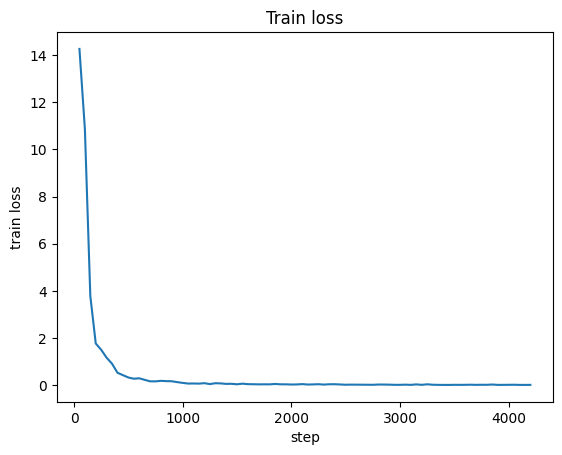

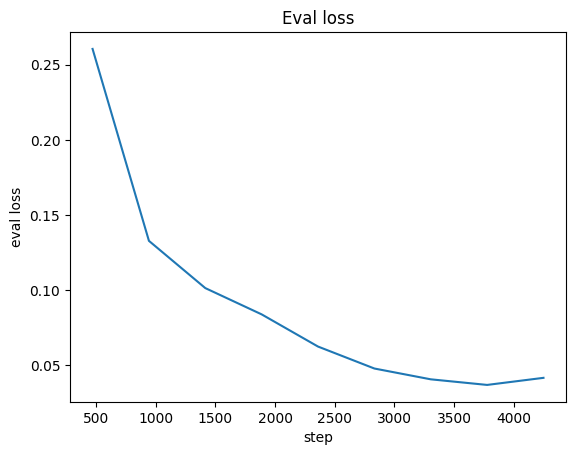

,text,label,pred_score,pred_label,abs_err
329,Vikar,Junior,5.164062,Management,4.164062
278,Marktondersteuning,Junior,5.125000,Management,4.125000
94,Partner,Management,1.213867,Junior,3.786133
462,Partner,Management,1.213867,Junior,3.786133
197,Partner,Management,1.213867,Junior,3.786133
377,Partner,Management,1.213867,Junior,3.786133
437,Partner,Management,1.213867,Junior,3.786133
375,Partner,Management,1.213867,Junior,3.786133
119,Arbeitgeber,Management,1.255859,Junior,3.744141
107,Departementssekretär Finanz,Professional,5.343750,Management,3.343750


In [19]:
reg_trainer_base, (reg_train_pred_base, reg_val_pred_base, reg_test_pred_base) = run_regression(
    train_df_base,
    test_df_base,
    out_dir="seniority_ft_reg_base"
)

# regression without synthetic data - if there were the same labels in train and test

To understand our model better, we now check how the performance would be if the label of test = labels of train

In [22]:
# now remove all labels that are professional from test_df_base
train_df_base = df_seniority[["text", "label"]].copy()
test_df_base = df_seniority_test[["text", "label"]].copy()
test_df_known_labels = test_df_base[test_df_base["label"] != "Professional"].copy()


Map:   0%|          | 0/7542 [00:00<?, ? examples/s]

Map:   0%|          | 0/1886 [00:00<?, ? examples/s]

Map:   0%|          | 0/407 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2199740445.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mae,Acc Thresh,F1 Macro
1,0.600300,0.263083,0.362340,0.819194,0.562573
2,0.150800,0.131047,0.252986,0.921527,0.687978
3,0.057600,0.078608,0.210521,0.978791,0.809399
4,0.049500,0.072410,0.204929,0.992047,0.989713
5,0.030300,0.056642,0.174947,0.992047,0.822608
6,0.030200,0.054484,0.190461,0.995228,0.828969
7,0.040500,0.047489,0.183596,0.994698,0.828413


early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled


Evaluation based on training data: {'train_loss': 0.034846510738134384, 'train_mae': 0.16719262301921844, 'train_acc_thresh': 0.9980111376292761, 'train_f1_macro': 0.8310099126655972, 'train_runtime': 4.0656, 'train_samples_per_second': 1855.055, 'train_steps_per_second': 58.047, 'epoch': 7.0}
Evaluation based on val data:   {'val_loss': 0.05664170905947685, 'val_mae': 0.1749468296766281, 'val_acc_thresh': 0.9920466595970308, 'val_f1_macro': 0.8226080631380763, 'val_runtime': 1.0379, 'val_samples_per_second': 1817.076, 'val_steps_per_second': 56.844, 'epoch': 7.0}
Evaluation based on test data:  {'test_loss': 0.7608034610748291, 'test_mae': 0.5331443548202515, 'test_acc_thresh': 0.7223587223587223, 'test_f1_macro': 0.5166811815099513, 'test_runtime': 0.2325, 'test_samples_per_second': 1750.402, 'test_steps_per_second': 55.91, 'epoch': 7.0}


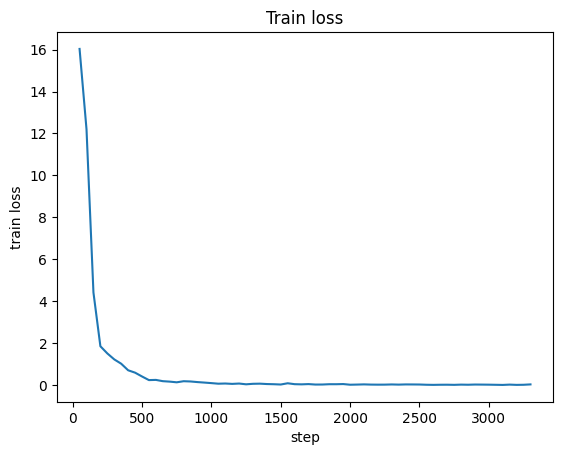

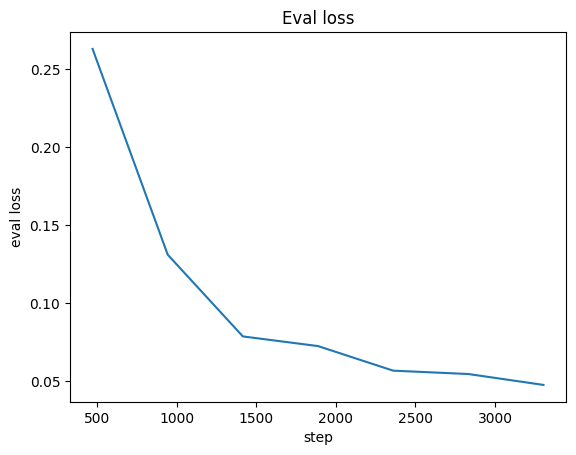

,text,label,pred_score,pred_label,abs_err
51,Partner,Management,1.419922,Junior,3.580078
256,Partner,Management,1.419922,Junior,3.580078
294,Partner,Management,1.419922,Junior,3.580078
129,Partner,Management,1.419922,Junior,3.580078
257,Partner,Management,1.419922,Junior,3.580078
312,Partner,Management,1.419922,Junior,3.580078
226,Vikar,Junior,4.468750,Lead,3.468750
187,Marktondersteuning,Junior,4.250000,Lead,3.250000
338,Managing Sr. Underwriting Director,Senior,6.242188,Director,3.242188
309,Administrateur suppléant/ Membre des Commissio...,Junior,3.992188,Lead,2.992188


In [23]:
reg_trainer_base_known_labels, (reg_train_pred_base, reg_val_pred_base, reg_test_pred_base) = run_regression(
    train_df_base,
    test_df_known_labels,
    out_dir="seniority_ft_reg_base_known_labels"
)

## Classification with Synthetic Data

Gemini -> because then we also have label professional -> we use oversampling to get better representation of professional

In [ ]:
train_df_aug = add_synthetic(train_df_base, "data/results/gemini_synthetic.csv")

In [ ]:
# show how often the different labels occur in train_df_aug

train_df_aug["label"].value_counts()

In [ ]:
cls_trainer_syn, (cls_train_pred_syn, cls_val_pred_syn, cls_test_pred_syn), (label2id_syn, id2label_syn) = run_classification(
    train_df_aug,
    test_df_base,
    out_dir="seniority_ft_cls_syn"
)